# Power laws in avalanche statistics
#### QLS Project

Simulation of $N$ neurons as $N$ copies of the same inhomogeneous Poisson process; physically this represent a neaural network in which neurons' fire are decorrelated but all of them fire with the same firing rate $v(t)$.

The firing rate has a time correlation in order to produce power laws (recall: neurons firing with a set of firing rates $\lambda_i$ which are i.i.d. variables don't display power law statistics in the avalanches, see the other jupyther), and it is generated by means of a Ornestein-Uhlenbeck process.

This simulation is base on the *Touboul and Destexche*'s paper *PHYSICAL REVIEW E 95, 012413 (2017)*

#### Appendix: Correlation function
The correlation fucntion for the O-U process is
$$ C (\tau) = \frac{\sigma^2}{2 \alpha} e^{-\alpha |\tau|} $$

The decorrelation time is $1/\alpha$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def positive(x): 
    ''' returns the []_+ of an array or a list '''
    for idx, elem in enumerate(x):
        if elem <= 0: x[idx] = 0
    return x

## Firing rate
Here the firing rate is generated for $T$ seconds. In the original paper, the stochastic process used was a Ornstein-Ulhenbeck process and a Brownian motion with suitable boundary condititions. Here the OU is presented.

The OU process is discretized using the Euler-Maruyama method in which the solution of the Langevin is discretized as followed (in the context of Ito's prescription):
$$  \rho_{t+1} = \rho_t + dt (-\alpha \rho_t) + \sigma dW_t $$
where, and this is **important** [see Higham'a paper], $dW_t$ is the Wiener incrememnt choosen at each timestep as
$$ dW \sim \sqrt{dt} N(0,1) $$

Why is it the case? In the Wiener process, what are i.i.d. are the increments $dW$ which are distributed as gaussian variable with variance $dt$, where $dW = W_{t+dt} - W_t$.
Basically, this is related to the Ito's prescription and to the fact that stochastic ito intergals related to a Wiener process has increments of order $\sim \sqrt{dt}$; recall $(dW)^2 = dt$.

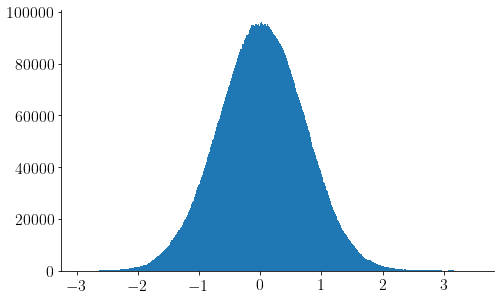

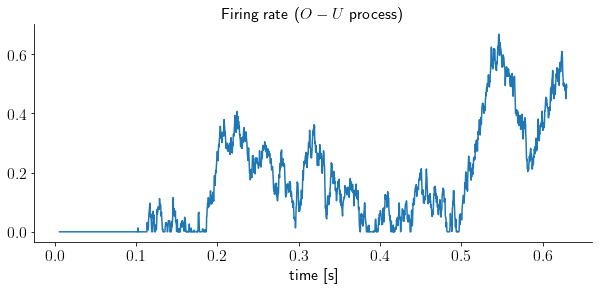

In [20]:
# Parameters for the simulation
T = 8000 # time of sim in s
dt = 0.0003 # time step 
# usually it is about 1ms (https://praneethnamburi.com/2015/02/05/simulating-neural-spike-trains/)
# 3 ms is the mean duration of a spike, hence this choice

# NOTE: the results are dependent on the choice of dt, because this affects duration and sizes
# of avalanches. [see Faggin's Thesis]

n = int(T/dt) # total time steps
t = np.linspace(0., T, n) # vector of times.

# Quantities for O-U precess
alpha = 1 # value from fig2 
sigma = 1 # value from fig2
rho = np.zeros(n)
# O-U
np.random.seed(1010) # for reproducible firing rates
for i in range(n - 1):
    rho[i + 1] = rho[i] - dt*alpha*rho[i] + np.sqrt(dt)*sigma*np.random.randn() 
    
plt.hist(rho,bins='auto')

rho = positive(rho) # set negative part to 0

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
ax.set_title("Firing rate ($O-U$ process)")
ax.set_xlabel("time [s]")
#ax.axes.get_yaxis().set_visible(False)
ax.plot(t[20:2100],rho[20:2100]) # only a small part is displayed for graphical purposes
plt.savefig('img_main/firing_rate_OU_dt_{}'.format(dt), format='pdf')

Important variables:
* $\rho$ = firing rate
* $n,dt,T$

## Spike train

The non homogeneous Poisson processes are generated by means of the *thinning* method.
This method consist in generating $N$ realization of a *homogeneous* poisson process and independently accept spikes based on the firing rate. For more detail see the Algorithm 6 in the Higham's work.


This process is also described at pg 30 of Abbott and Dayan. This is meant to simulate a firing rate which depend at any given time only on the value of a physical parameter (recall the angle) in *that* moment, and not in its recent history.  One possible aspect which invalidates this assumpion is the refractory period.

In [21]:
# Spike train generation

N_neurons = 2000 # number used in Touboul paper
S_shape_ = np.zeros(n) # temporal profile of hte sum of all neurons' spikes

max_rho = np.max(rho)

for neuron in range(N_neurons):
    
    # Algo 6 from Higham's paper
    time = 0 # starting time for the homogeneous process [bins]
    while time < n:
        u = np.random.random()
        interspike_t = int( (- np.log(u)/max_rho)/dt )  # /dt to convert it in bins
        time += interspike_t
        
        if time > n-1: break
        
        v = np.random.random()
        if v <= rho[time]/max_rho :
            S_shape_[time] += 1

Important variables:
* $S_{shape}\_$, avalanches's temporal profile
* $N_{neurons}$ = neuron's number

## Identify the binning $\Delta t$
Idea: I have a dataset like the one recorded in a experiment. My instrument gives me a discretization of time.
The goal is to define a time bin $\Delta t$ in the units of my timestep (defined a priori by the instrument or by me in this case) $dt$.

Procedure: identify the location of spikes, compute the intermediate distance between any two spikes $t^*$, then perform a mean $<t^*>$. Then, my neu timebin is $<t^*>$ espress in units of $dt$

In [22]:
where_spikes = np.where(S_shape_ != 0)
interspike_time = (where_spikes - np.roll(where_spikes,1))
interspike_time = np.delete(interspike_time,0) # remouve the first element

mean_interspike_time = np.sum(interspike_time)/len(interspike_time)
mean_interspike_time = int(mean_interspike_time)
print("Mean interspike time [dt units]:", mean_interspike_time)

# Now I modify the S_shape_ in order to applay the ney binning

rest = int(n%mean_interspike_time)
if rest == 0:
    n_reduced = int(n/mean_interspike_time)
else:
    n_reduced = int((n-rest)/mean_interspike_time)
    
S_shape = np.zeros(n_reduced)
delta = mean_interspike_time
# In this procedure, I'm ignoring "rest" numeber of point in S_shape_, not important
for i in range(0, n-rest, mean_interspike_time):
    
    j = int(i/mean_interspike_time)
    S_shape[j] = S_shape_[i:i+delta].sum()
    

Mean interspike time [dt units]: 7


Important variables:
* $S_{shape}$
* $n_{reduced}$

## Algorithm to identify avalanches
This generates two arrays in which there are stored the times (in bins) in which an avalanche starts and ends

In [23]:
# Avalanche finder
t_in = [] # timestep in which avalanche starts
t_fin = [] #                            ends
avalanche = False

for timestep in range(n_reduced):
    
    if S_shape[timestep] != 0:
        if avalanche == False:
            t_in.append(timestep) # lists faster than array in this
            avalanche = True
    if S_shape[timestep] == 0 and avalanche == True:
        t_fin.append( timestep ) 
        avalanche = False

# Erase the last avalanche if the last element of S_shape is != 0
if len(t_in) != len(t_fin):
    t_in.pop(-1)
    
# convert them into arrays for efficiency purposes
t_in = np.array(t_in)
t_fin = np.array(t_fin)

Important variables:
* $t_{in}$, $t_{fin}$
Note: the same index in the above arrays refers to the same avalanche

# Plot and power law test
The code and the subroutines are base on the *Gerlach and Altmann*'s paper. All the codes can be found in [here](https://github.com/martingerlach/testing-statistical-laws-in-complex-systems)

The basic idea is to minimize the log-likelihood to obtain the scaling exponent $\alpha$ of $x^{-\alpha}$.

In [9]:
# Libreries
import sys, os
import pandas as pd

%load_ext autoreload
%autoreload 2
import matplotlib.cm as cm # color map
cmap = cm.tab10

## custom packages
src_dir = os.path.join(os.pardir,'testing-statistical-laws-in-complex-systems/src')
sys.path[0] = src_dir

from data_io_ts import *
from stats import xdata_to_xnx, x_autocorr_sm_ext
from powerlaw_fit import *

from modules_plotting import * # import setup for figure layout (see src/modules_plotting.py to customize)

## Size distribution

In [24]:
### Size distribution 
sizes = []
for i in range(len(t_in)):
    if S_shape[t_in[i]:t_fin[i]].sum() == 0: print("ERROR: zeros inside sizes!") # control
    sizes.append( S_shape[t_in[i]:t_fin[i]].sum() )

We need to estimate $\alpha$ and $x_{min}$. The estimation of $x_{min}$ is done by means of the miniization of the Kolmogorov-Smirnov distance, as described by Newman et al.
Since this methods doesn't rely on the independence assumption it is suitable for the purpose.

One inportant point in the analysis is the *parameter window* in which I chose to test the power law hypothesis. This affects the final estimation of the scaling exponent and the p-value, see *Bauke*.

Best KS: 0.0035062575746654945
Best x_min: 37


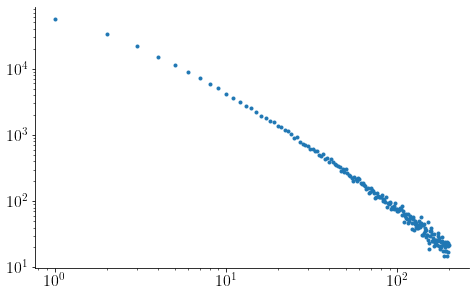

In [27]:
# minimization of KS and plot to check xmax

# Xmax is choosen to find the parameter's window in which the p-value accept the power law hypothesis
xmax = 2*10**2

x,nx = xdata_to_xnx(sizes, norm=False,xmin=1,xmax=xmax)

# plot for xmin = 1
plt.loglog(x,nx, ".")

KS_best = 10**(5)
xmin_best = 0
for xmin in range(1,90):
    x,nx = xdata_to_xnx(sizes, norm=False,xmin=xmin,xmax=xmax)
    result = fit_power_disc_sign(x, nx, xmin=xmin, xmax=xmax, nrep_synth=0)
    
    KS = result['KS']
    # Questo KS risulta inconsistente con quello calcolato con KS_stat
    # Questo perchè il results qua sopra, tiene conto del xmin e del xmax
    # quando va a calcolare le cdf. Quindi preferisco appoggiarmi su questo metodo
    
    if KS < KS_best:
        KS_best = KS
        xmin_best = xmin
        #print(KS_best)
        
print("Best KS:", KS_best)
print("Best x_min:", xmin_best)

Result method:

The fit_power_disc_sign method compute $\alpha$ using the discete method (the exact one) described in *Clauset et al*. This is correct because our power law is based on a discrete parameter.

This is done by numerically solve the roots of the equation (see modules for more details)

$$ \frac{\zeta'(\hat{\alpha},x_{min})}{\zeta(\hat{\alpha},x_{min})} 
 + \frac{1}{N_{sample}} \sum_{i=1}^n \log x_i  = 0$$

In [28]:
### Fit and Goodnees-of-fit test by means of p-value

# Empirical distribution
xmin = 37 # choosen by minimizing KS, see Clauset et al.
x,nx = xdata_to_xnx(sizes, norm=False,xmin=xmin,xmax=xmax)

N = np.sum(nx)
px = nx/N # normalized distribution

nrep_synth = 100 ## number of synthetic datasets to generate for empirical p-value
# recall that, if we want an error in the p-value of epsilon, we need
# to generate 1/4 epsilon**-2 samples [Clauset et al.]. Hence 100 -> epsilon = 0.05. 
result = fit_power_disc_sign(x, nx, xmin=xmin, xmax=xmax, nrep_synth=nrep_synth)
alpha = result['alpha'] ## fitted parameter alpha
px_fit = pdf_power_disc(x, xmin,xmax,alpha)

pval = result['pval'] ## p-value
KS = result['KS'] ## KS-distance

print('Original dataset. N = %s'%(N))
print('Empirical p-value from %s synthetic datasets: '%(nrep_synth), pval)
print("Alpha:", alpha)

# exponent and error
tau_exp = alpha
tau_error = (tau_exp - 1)/np.sqrt(len(x)) # 3.2 Clauset, approximation of the descrete case

Original dataset. N = 15902
Empirical p-value from 100 synthetic datasets:  0.81
Alpha: 1.908745436127739


Generating 100 synthetic datasets, we have a 0.05 error in the p-value [Clauset et al., the the above cell]

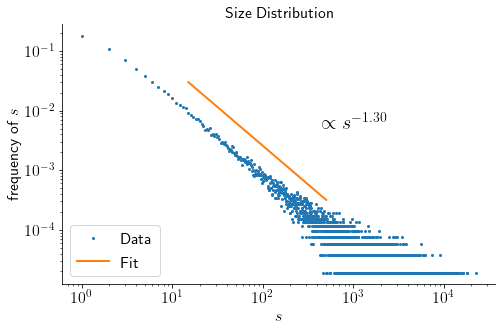

In [18]:
### Plot
fig, ax = plt.subplots(nrows=1, ncols=1)

## Plot the distribution
x,nx = xdata_to_xnx(sizes, norm=False,xmin=1,xmax=None) # to plot the whole dataset
N = np.sum(nx)
px = nx/N

x_ = x
y_ = px

c_ = cmap(0)
ax.plot(x_,y_,marker='o',ms=2,lw=0,c = c_,label = 'Data')

## Plot the fit
x,nx = xdata_to_xnx(sizes, norm=False,xmin=xmin,xmax=xmax) # to plot only the fit
c_ = cmap(1)
x_ = x
y_ = px_fit
plt.plot(x_,y_,lw=2,c=c_, label = 'Fit')


## Layout stuff
ax.legend(loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

#ax.set_xlim(1,10**3)
#ax.set_ylim(2*10**(-5),10**(-1))

ax.set_xlabel(r'$s$')#,labelpad=0)
ax.set_ylabel(r'frequency of $s$')
ax.set_title('Size Distribution')

x_annot_formula = 0.6
y_annot_formula = 0.6
ax.annotate(r'$\propto s^{-1.30}$',xy=(x_annot_formula,y_annot_formula),xycoords = 'axes fraction',size=20)

plt.savefig("img_main/size_tau_{}".format(tau_exp),format='pdf')

### There is correlation in data?
This section follow the work by *Gerlach* in which there is a lucid analysis of the underline hypothesis of the max log-likelihood process used by *Clauset et al*.

Here the idea is to check for correlazion in data, which can lead to a smaller number of degreee of freedom, thus in rejecting a legit power law.

Note: this analysis is unnecessary because the power law hypothesis are already been accepted, but it's an additional test for the uncorrelation of data and goodnees of the previous analysis

In [12]:
N = len(sizes)

np.random.seed(42)

nrep = 10**3
q1,q2 = 1,99
result = x_autocorr_sm_ext(np.log(sizes),nrep=nrep,q=[q1,q2]) 
# the log of the dataset leads to a more 'conservative'
# estimation of tua*, see Gerlach
x = result['tau']
y_mu,y_1,y_2 = result['C']
y_mu_rand,y_1_rand,y_2_rand = result['C_rand']

## here we calculate from t=0,1,...,t^* where t^* is the first point
## where true C(t) is within the q-percentiles of the random

# ind_t_star = np.where( (y_mu<=y_2_rand)&(y_mu>=y_1_rand) )[0][1]
ind_t_star = np.where(y_1<=y_2_rand)[0][2]
tau_star = x[ind_t_star]

print('Autocorrelation time: ',tau_star)

Autocorrelation time:  3


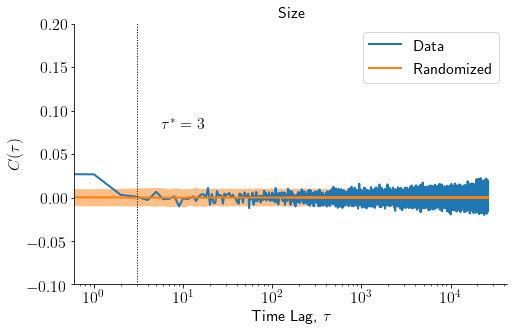

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)

alpha_val = .5
## Plot the empirical autocorrelation
x_ = x
y_ = y_mu
z1_ = y_1
z2_ = y_2
c_ = cmap(0)
ax.plot(x_,y_,c = c_,lw=lw, label = 'Data')
ax.fill_between(x_,z1_,z2_,color=c_,alpha=alpha_val,lw=0)



## Plot the randomized autocorrelation
x_ = x
y_ = y_mu_rand
z1_ = y_1_rand
z2_ = y_2_rand
c_ = cmap(1)
ax.plot(x_,y_,c = c_,lw=lw, label = 'Randomized')
ax.fill_between(x_,z1_,z2_,color=c_,alpha=alpha_val,lw=0)


ax.plot([tau_star,tau_star],[-1,1],lw=1,color='black',ls=':')


## Layout stuff
ax.legend(loc='upper right')

ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel(r'Time Lag, $\tau$')#,labelpad=0)
ax.set_ylabel(r'$C(\tau)$')
ax.set_ylim(-0.1,0.2)
ax.set_title('Size')


x_annot_tau = 0.2
y_annot_tau = 0.6
ax.annotate(r'$\tau^*=%s$'%(int(tau_star)),xy=(x_annot_tau,y_annot_tau),xycoords = 'axes fraction')

plt.savefig("size_corr_{}".format(tau_star),format='pdf')

## Duration distribution

In [29]:
# Duration distribution
duration = np.array(t_fin - t_in)  # number of bins

# for the time correlation
mean_duration = int(np.mean(duration))
print("Mean duraton of an avalanche:\nBins:", mean_duration,
      "\nSeconds:", mean_duration*dt)


Mean duraton of an avalanche:
Bins: 6 
Seconds: 0.0018


Best KS: 0.0037386322118203585
Best x_min: 15


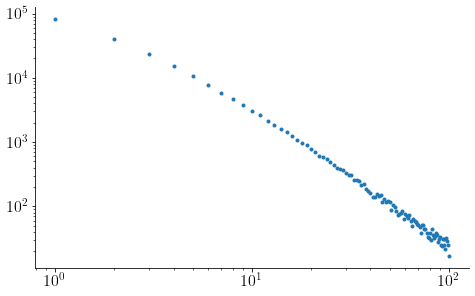

In [30]:
# minimization of KS and plot to check xmax

# Xmax is choosen to find the parameter's window in which the p-value accept the power law hypothesis
xmax = 10**2

x,nx = xdata_to_xnx(duration, norm=False,xmin=1,xmax=xmax)

# plot for xmin = 1
plt.loglog(x,nx, ".")

KS_best = 10**(5)
xmin_best = 0
for xmin in range(1,90):
    x,nx = xdata_to_xnx(duration, norm=False,xmin=xmin,xmax=xmax)
    result = fit_power_disc_sign(x, nx, xmin=xmin, xmax=xmax, nrep_synth=0)
    KS = result['KS']
    # Questo KS risulta inconsistente con quello calcolato con KS_stat
    # Questo perchè il results qua sopra, tiene conto del xmin e del xmax
    # quando va a calcolare le cdf. Quindi preferisco appoggiarmi su questo metodo
    
    if KS < KS_best:
        KS_best = KS
        xmin_best = xmin
        #print(KS_best)
        
print("Best KS:", KS_best)
print("Best x_min:", xmin_best)

Here, in the duration data with $x_{max} = inf$, we know a sub sampling effect. Here the upper bound, a.k.a. $x_{max}$ is justified.

In [31]:
### Fit
# Empirical distribution
xmin = 15

x,nx = xdata_to_xnx(duration, norm=False,xmin=xmin,xmax=xmax)

N = np.sum(nx)
px = nx/N # normalized distribution

nrep_synth = 100 ## number of synthetic datasets to generate for empirical p-value
# recall that, if we want an error in the p-value of epsilon, we need
# to generate 1/4 epsilon**-2 samples 
result = fit_power_disc_sign(x, nx, xmin=xmin, xmax=xmax, nrep_synth=nrep_synth)
alpha = result['alpha'] ## fitted parameter alpha
px_fit = pdf_power_disc(x, xmin,xmax,alpha)

pval = result['pval'] ## p-value
KS = result['KS'] ## KS-distance

print('Original dataset. N = %s'%(N))
print('Empirical p-value from %s synthetic datasets: '%(nrep_synth), pval)
print("Alpha:", alpha)

# exponent and error
alpha_exp = alpha
alpha_error = (alpha_exp - 1)/np.sqrt(len(x)) # 3.2 Clauset, approximation of the descrete case

Original dataset. N = 17367
Empirical p-value from 100 synthetic datasets:  0.64
Alpha: 2.168941710493567


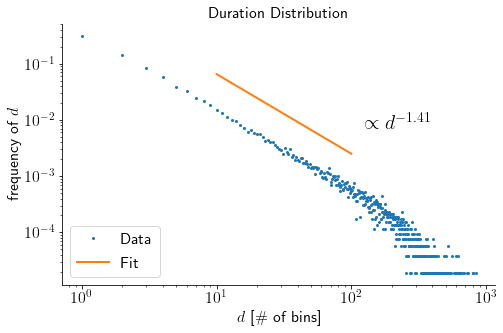

In [26]:
### Plot
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)

## Plot the distribution
x,nx = xdata_to_xnx(duration, norm=False,xmin=1,xmax=None) # to plot the whole dataset
N = np.sum(nx)
px = nx/N
x_ = x
y_ = px

c_ = cmap(0)
ax.plot(x_,y_,marker='o',ms=2,lw=0,c = c_,label = 'Data')

## Plot the fit
x,nx = xdata_to_xnx(duration, norm=False,xmin=xmin,xmax=xmax) # to plot only the fit
c_ = cmap(1)
x_ = x
y_ = px_fit
plt.plot(x_,y_,lw=2,c=c_, label = 'Fit')


## Layout stuff
ax.legend(loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

#ax.set_xlim(1,10**3)
#ax.set_ylim(2*10**(-5),3*10**(-1))

ax.set_xlabel(r'$d$ [$\#$ of bins]')#,labelpad=0)
ax.set_ylabel(r'frequency of $d$')
ax.set_title('Duration Distribution')

x_annot_formula = 0.7
y_annot_formula = 0.6
ax.annotate(r'$\propto d^{-1.41}$',xy=(x_annot_formula,y_annot_formula),xycoords = 'axes fraction',size=20)

plt.savefig("img_main/duration_alpha_{}".format(alpha_exp),format='pdf')

### There is correlation in data?

In [27]:
N = len(duration)

np.random.seed(42)

nrep = 10**3
q1,q2 = 1,99
result = x_autocorr_sm_ext(np.log(duration),nrep=nrep,q=[q1,q2])
x = result['tau']
y_mu,y_1,y_2 = result['C']
y_mu_rand,y_1_rand,y_2_rand = result['C_rand']

## here we calculate from t=0,1,...,t^* where t^* is the first point
## where true C(t) is within the q-percentiles of the random

# ind_t_star = np.where( (y_mu<=y_2_rand)&(y_mu>=y_1_rand) )[0][1]
ind_t_star = np.where(y_1<=y_2_rand)[0][2]
tau_star = x[ind_t_star]

print('Autocorrelation time: ',tau_star)

Autocorrelation time:  3


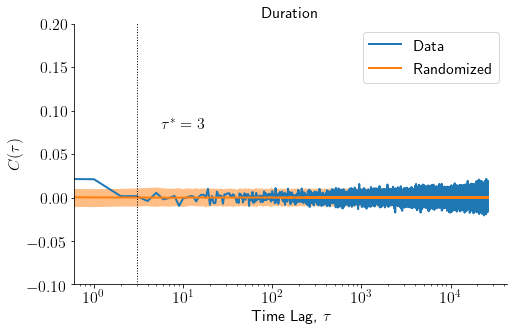

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)

alpha_val = .5
## Plot the empirical autocorrelation
x_ = x
y_ = y_mu
z1_ = y_1
z2_ = y_2
c_ = cmap(0)
ax.plot(x_,y_,c = c_,lw=lw, label = 'Data')
ax.fill_between(x_,z1_,z2_,color=c_,alpha=alpha_val,lw=0)



## Plot the randomized autocorrelation
x_ = x
y_ = y_mu_rand
z1_ = y_1_rand
z2_ = y_2_rand
c_ = cmap(1)
ax.plot(x_,y_,c = c_,lw=lw, label = 'Randomized')
ax.fill_between(x_,z1_,z2_,color=c_,alpha=alpha_val,lw=0)


ax.plot([tau_star,tau_star],[-1,1],lw=1,color='black',ls=':')


## Layout stuff
ax.legend(loc='upper right')

ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel(r'Time Lag, $\tau$')#,labelpad=0)
ax.set_ylabel(r'$C(\tau)$')
ax.set_ylim(-0.1,0.2)
ax.set_title('Duration')


x_annot_tau = 0.2
y_annot_tau = 0.6
ax.annotate(r'$\tau^*=%s$'%(int(tau_star)),xy=(x_annot_tau,y_annot_tau),xycoords = 'axes fraction')

plt.savefig("img_main/duration_corr",format='pdf')

## Avalanche mean size vs Duration
Analysis relative to the mean size of an avalanche of a given duration

In [32]:
duration_uni = np.unique(duration).astype(int) # uniques durations of avalanches
sizes_mean = [] # Temporal mean shape for an avalanche of a given duration

for time in duration_uni:
    
    temp = 0
    counter = 0
    
    for i in range(len(t_in)):
        if t_fin[i] - t_in[i] == time:
            temp += sizes[i]
            counter += 1

    sizes_mean += [int(temp/counter)]
    
sizes_mean = np.array(sizes_mean, dtype='int')

For the determination of the scaling factor, in this case it is used a linear regression of the log log of data.
The linear regression is performed by means of the module `scipy.stats.linregress` which minimize the least-squares

In [33]:
from scipy.stats import linregress

a = 10 # avoid the tail from the fit; results doesn't change to much if a = 0 (within 2 std_err)
x = duration_uni
nx = sizes_mean
x_log = np.log10(duration_uni)[:-a]
nx_log = np.log10(sizes_mean)[:-a]

slope, intercept, r_value, p_value, std_err = linregress(x_log, nx_log)

print('r value:', r_value)
print('intercept:', intercept)
print('slope:', slope)
print('Std for the slope:', std_err)

# the std_error is computed as
# sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
# where
# ssxm, ssxym, ssyxm, ssym = np.cov(x, y, bias=1).flat
# r_value = r
# and df = degrees of freedom = n - 2

# Gamma exponent
gamma = slope

r value: 0.9978888320845859
intercept: 0.1229294018413829
slope: 1.2502045356248332
Std for the slope: 0.0038702125901099137


### Crackling noise relation
Conparison between the fit and the prediction given by the Crackling noise relationhip

In [34]:
# gamma from the relation
gamma_crackling = (alpha_exp - 1)/(tau_exp - 1)
# error propagation; assuming uncorrelated errors
gamma_crackling_error = np.sqrt( alpha_error**2/tau_exp**2 + 
                                (alpha_exp**2/tau_exp**4) * tau_error**2  )

print('Gamma obtained in the fit:', gamma, '+-', std_err)

print('Gamma obtained through the crackling rel.:', gamma_crackling, '+-', gamma_crackling_error)


Gamma obtained in the fit: 1.2502045356248332 +- 0.0038702125901099137
Gamma obtained through the crackling rel.: 1.28632471099338 +- 0.07839429791219668


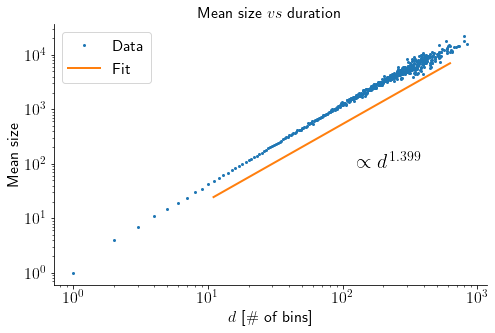

In [35]:
### Plot
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)

## Plot the distribution
x_ = x
y_ = nx

c_ = cmap(0)
ax.plot(x_,y_,marker='o',ms=2,lw=0,c = c_,label = 'Data')

## Plot the fit
c_ = cmap(1)
x_ = x[10:-a]
y_ = np.array([ (10**intercept-1)*(t**slope) for t in x[10:-a] ])
# here intercept and x range are modified for visual purposes
plt.plot(x_,y_,lw=2,c=c_, label = 'Fit')


## Layout stuff
ax.legend(loc='upper left')

ax.set_xscale('log')
ax.set_yscale('log')

#ax.set_xlim(1,10**3)
#ax.set_ylim(9*10**(-5),2*10**(-1))

ax.set_xlabel(r'$d$ [$\#$ of bins]')#,labelpad=0)
ax.set_ylabel(r'Mean size')
ax.set_title('Mean size $vs$ duration')

x_annot_formula = 0.7
y_annot_formula = 0.45
ax.annotate(r'$\propto d^{\,1.399}$',xy=(x_annot_formula,y_annot_formula),xycoords = 'axes fraction',size=20)

plt.savefig("img_main/avg_size_duration_gamma_{}".format(gamma),format='pdf')

## Avalanche shape and collapse into a universal scaling function
Here we take as example, as it is in the Touboul's paper, a family of spike shape and rescale the time axes by their duration $T$ and the avg sizes by $T^{\gamma - 1}$, where $\gamma$ is the scaling exponent which relates duration with mean sizes.

This is how it works [25 in Touboul's paper]: We take avalnches of duration between 20 and 40 bins, then we average their temporal shapes and plot it with respect to the duration

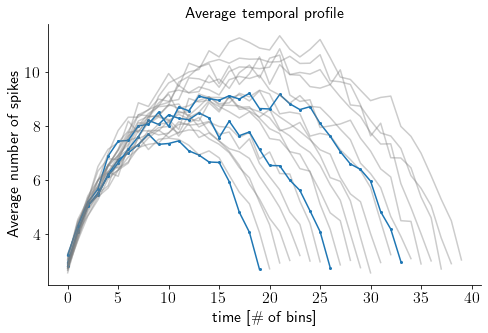

In [36]:
shape_mean = [] # mean temporal shapes

dur = duration_uni[19:40]

for d in dur:
    
    shape_temp = np.zeros(d)
    counter = 0

    for i in range(len(t_in)):
        if t_fin[i] - t_in[i] == d:
            shape_temp = shape_temp + S_shape[t_in[i]:t_fin[i]]
            counter += 1
    
    shape_mean += [shape_temp/counter]
    
shape_mean = np.array(shape_mean)

#c_ = cmap(0)
#ax.plot(x_,y_,marker='o',ms=2,lw=0,c = c_,label = 'Data')
#ax.set_xlabel(r'$d$')#,labelpad=0)
#ax.set_ylabel(r'$p(d)$')
#ax.set_title('Duration Distribution')


# Plot
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.set_title('Average temporal profile')
ax.set_xlabel('time [$\#$ of bins]')
ax.set_ylabel('Average number of spikes')
for curve in range(len(shape_mean)):
    
    t = [x for x in range(len(shape_mean[curve]))]
    if curve%7 == 0: # done for estetic purposes
        ax.plot(t,shape_mean[curve], marker='o', c = cmap(0), ms=2 )
    else:
        ax.plot(t,shape_mean[curve], c = 'grey', alpha= .4)
        
plt.savefig("img_main/temporal_profile_dt_{}".format(dt),format='pdf')

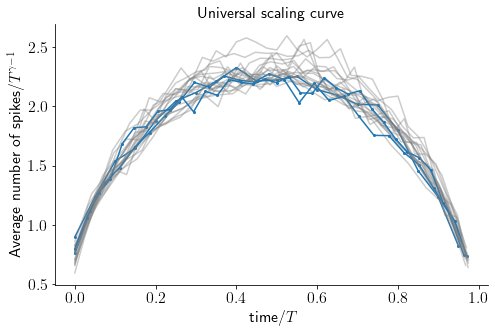

In [37]:
# Collapse

c_exp = gamma - 1 # exponent of mean size vs duration
shape_mean_scaled = np.copy(shape_mean)

fig, ax = plt.subplots(nrows=1,ncols=1)
ax.set_title('Universal scaling curve')
ax.set_xlabel('time$/T$')
ax.set_ylabel('Average number of spikes$/T^{\gamma-1}$')
for curve in range(len(shape_mean)):
    
    duration = len(shape_mean[curve]) # duration of the avalanche
    t = np.array([x/duration for x in range(duration)])
    
    for i in range(len(shape_mean[curve])):
        shape_mean_scaled[curve][i] /= duration**c_exp
    
    if curve%7 == 0: # done for estetic purposes
        plt.plot(t,shape_mean[curve], marker = 'o', c = cmap(0), ms=2 )
    else:
        plt.plot(t,shape_mean[curve], c = 'grey', alpha= .4)

plt.savefig("img_main/temporal_profile_collapse_dt_{}".format(dt),format='pdf')